In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


In [4]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 11.5 MB/s eta 0:00:00


In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [6]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [7]:
class ShipDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if len(self._load_target(id)) > 0]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)

        # Filtrer les boîtes englobantes invalides (largeur ou hauteur nulle)
        target = [t for t in target if t['bbox'][2] > 0 and t['bbox'][3] > 0]

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

            image = transformed['image']
            boxes = transformed['bboxes']

            new_boxes = []  # convert from xywh to xyxy
            for box in boxes:
                xmin, ymin, width, height = box[:4]
                xmax = xmin + max(0.1, width)  # ajuster x_max si x_min est égal à x_max
                ymax = ymin + max(0.1, height)  # ajuster y_max si y_min est égal à y_max

                # Vérification de la validité des coordonnées de la boîte englobante
                if xmax > xmin and ymax > ymin:
                    new_boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.tensor(new_boxes, dtype=torch.float32)

            targ = {}  # here is our transformed target
            targ['boxes'] = boxes
            targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
            targ['image_id'] = torch.tensor([t['image_id'] for t in target])
            targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # we have a different area
            targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
            return image.div(255), targ  # scale images

    def __len__(self):
        return len(self.ids)

In [8]:
dataset_path = "/kaggle/input/navires"

In [9]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'ships', 'supercategory': 'none'},
 1: {'id': 1, 'name': '0', 'supercategory': 'ships'},
 2: {'id': 2, 'name': '1', 'supercategory': 'ships'},
 3: {'id': 3, 'name': '2', 'supercategory': 'ships'},
 4: {'id': 4, 'name': '3', 'supercategory': 'ships'},
 5: {'id': 5, 'name': '4', 'supercategory': 'ships'},
 6: {'id': 6, 'name': '5', 'supercategory': 'ships'},
 7: {'id': 7, 'name': '6', 'supercategory': 'ships'},
 8: {'id': 8, 'name': '7', 'supercategory': 'ships'},
 9: {'id': 9, 'name': '8', 'supercategory': 'ships'},
 10: {'id': 10, 'name': '9', 'supercategory': 'ships'}}

In [10]:
classes = [i[1]['name'] for i in categories.items()]
classes

['ships', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [11]:
train_dataset = ShipDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


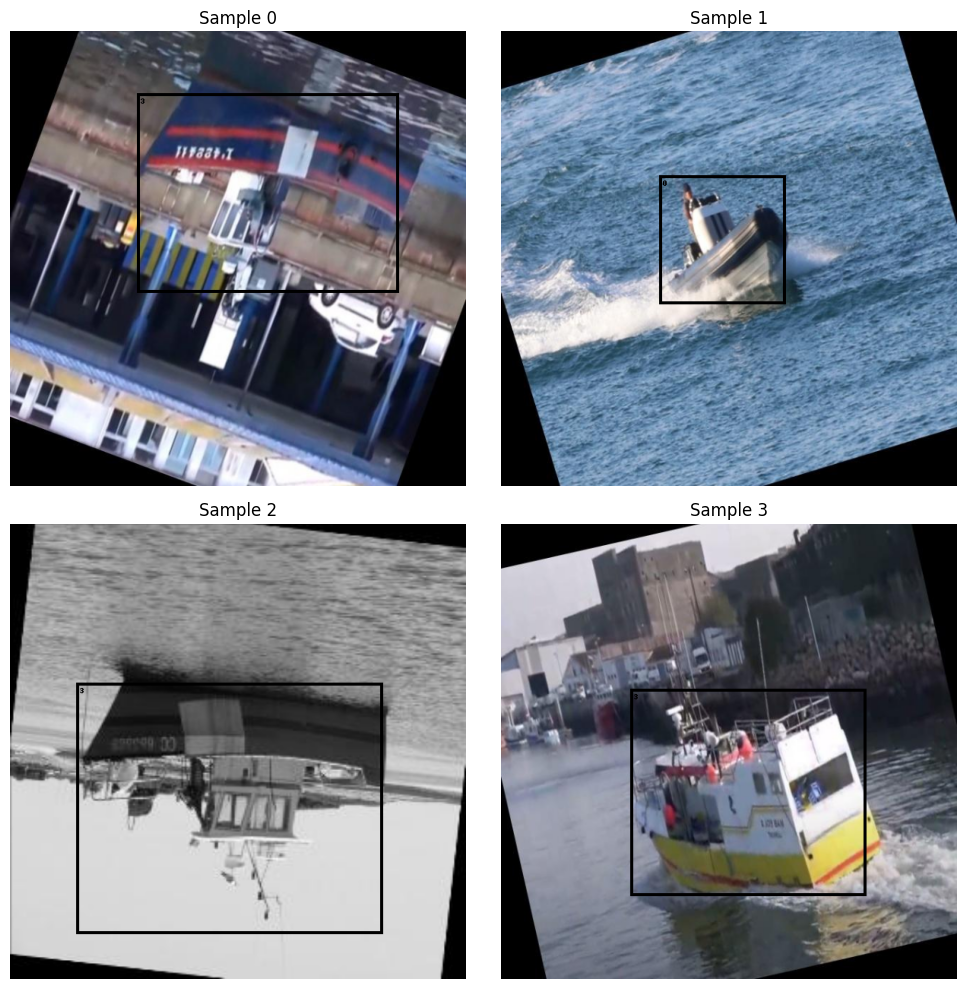

In [12]:
# Créer une figure avec une grille 2x2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Obtenir les 4 échantillons
samples = [train_dataset[i] for i in range(4)]

# Parcourir les échantillons et les afficher dans la grille
for i in range(2):
    for j in range(2):
        sample = samples[i*2 + j]
        img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
        img_with_boxes = draw_bounding_boxes(
            img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
        ).permute(1, 2, 0)

        # Afficher l'image dans la sous-figure correspondante
        axs[i, j].imshow(img_with_boxes)
        axs[i, j].set_title(f'Sample {i*2 + j}')  # Titre de l'image
        axs[i, j].axis('off')  # Désactiver les axes

# Afficher la figure
plt.tight_layout()
plt.show()

In [13]:
len(train_dataset)

2083

In [14]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 59.3MB/s]


In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [17]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [18]:
device = torch.device("cuda") # use GPU to train

In [19]:
model = model.to(device)

In [20]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [21]:
import sys

In [22]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Convertir les cibles en tensors et les envoyer au GPU
        
        optimizer.zero_grad()
        
        # Faire une prédiction
        loss_dict = model(images, targets)  # Le modèle calcule la perte automatiquement si nous passons les cibles
        
        # Calculer la perte totale
        losses = sum(loss for loss in loss_dict.values())
        
        # Rétropropagation et mise à jour des poids
        losses.backward()
        optimizer.step()
        
        # Enregistrer les pertes
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        all_losses_dict.append(loss_dict_append)
        all_losses.append(losses.item())
        
        if not math.isfinite(losses.item()):
            print(f"Loss is {losses.item()}, stopping training")
            print(loss_dict)
            sys.exit(1)
    
    # Afficher les statistiques d'entraînement
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [23]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 521/521 [01:12<00:00,  7.20it/s]


Epoch 0, lr: 0.010000, loss: 1.007015, loss_classifier: 0.539948, loss_box: 0.433750, loss_rpn_box: 0.019679, loss_object: 0.013639


100%|██████████| 521/521 [01:04<00:00,  8.08it/s]


Epoch 1, lr: 0.010000, loss: 0.900643, loss_classifier: 0.433709, loss_box: 0.441064, loss_rpn_box: 0.016730, loss_object: 0.009140


100%|██████████| 521/521 [01:03<00:00,  8.17it/s]


Epoch 2, lr: 0.010000, loss: 0.847067, loss_classifier: 0.389678, loss_box: 0.434388, loss_rpn_box: 0.015184, loss_object: 0.007817


100%|██████████| 521/521 [01:03<00:00,  8.25it/s]


Epoch 3, lr: 0.010000, loss: 0.826411, loss_classifier: 0.367632, loss_box: 0.437433, loss_rpn_box: 0.014588, loss_object: 0.006759


100%|██████████| 521/521 [01:03<00:00,  8.22it/s]


Epoch 4, lr: 0.010000, loss: 0.741788, loss_classifier: 0.311856, loss_box: 0.409140, loss_rpn_box: 0.013843, loss_object: 0.006949


100%|██████████| 521/521 [01:03<00:00,  8.24it/s]


Epoch 5, lr: 0.010000, loss: 0.741332, loss_classifier: 0.311659, loss_box: 0.410480, loss_rpn_box: 0.013278, loss_object: 0.005915


100%|██████████| 521/521 [01:03<00:00,  8.26it/s]


Epoch 6, lr: 0.010000, loss: 0.714491, loss_classifier: 0.285519, loss_box: 0.410914, loss_rpn_box: 0.012690, loss_object: 0.005368


100%|██████████| 521/521 [01:03<00:00,  8.26it/s]


Epoch 7, lr: 0.010000, loss: 0.689977, loss_classifier: 0.280782, loss_box: 0.392121, loss_rpn_box: 0.012369, loss_object: 0.004706


100%|██████████| 521/521 [01:02<00:00,  8.37it/s]


Epoch 8, lr: 0.010000, loss: 0.681363, loss_classifier: 0.264806, loss_box: 0.399885, loss_rpn_box: 0.012008, loss_object: 0.004663


100%|██████████| 521/521 [01:02<00:00,  8.39it/s]


Epoch 9, lr: 0.010000, loss: 0.660752, loss_classifier: 0.249715, loss_box: 0.394030, loss_rpn_box: 0.012191, loss_object: 0.004816


100%|██████████| 521/521 [01:02<00:00,  8.33it/s]


Epoch 10, lr: 0.010000, loss: 0.614300, loss_classifier: 0.229187, loss_box: 0.368934, loss_rpn_box: 0.011493, loss_object: 0.004686


100%|██████████| 521/521 [01:02<00:00,  8.38it/s]


Epoch 11, lr: 0.010000, loss: 0.612331, loss_classifier: 0.237828, loss_box: 0.358886, loss_rpn_box: 0.011221, loss_object: 0.004397


100%|██████████| 521/521 [01:02<00:00,  8.39it/s]


Epoch 12, lr: 0.010000, loss: 0.597952, loss_classifier: 0.225085, loss_box: 0.357861, loss_rpn_box: 0.011153, loss_object: 0.003853


100%|██████████| 521/521 [01:02<00:00,  8.38it/s]


Epoch 13, lr: 0.010000, loss: 0.594586, loss_classifier: 0.212611, loss_box: 0.367477, loss_rpn_box: 0.010919, loss_object: 0.003578


100%|██████████| 521/521 [01:01<00:00,  8.43it/s]


Epoch 14, lr: 0.010000, loss: 0.584634, loss_classifier: 0.216633, loss_box: 0.352931, loss_rpn_box: 0.011238, loss_object: 0.003832


100%|██████████| 521/521 [01:01<00:00,  8.41it/s]


Epoch 15, lr: 0.010000, loss: 0.544311, loss_classifier: 0.191505, loss_box: 0.339532, loss_rpn_box: 0.009893, loss_object: 0.003381


100%|██████████| 521/521 [01:01<00:00,  8.42it/s]


Epoch 16, lr: 0.010000, loss: 0.553670, loss_classifier: 0.200641, loss_box: 0.339357, loss_rpn_box: 0.010240, loss_object: 0.003433


100%|██████████| 521/521 [01:01<00:00,  8.44it/s]


Epoch 17, lr: 0.010000, loss: 0.568765, loss_classifier: 0.208763, loss_box: 0.345552, loss_rpn_box: 0.010822, loss_object: 0.003629


100%|██████████| 521/521 [01:01<00:00,  8.42it/s]


Epoch 18, lr: 0.010000, loss: 0.580304, loss_classifier: 0.217866, loss_box: 0.348524, loss_rpn_box: 0.010449, loss_object: 0.003464


100%|██████████| 521/521 [01:01<00:00,  8.49it/s]

Epoch 19, lr: 0.010000, loss: 0.557010, loss_classifier: 0.197642, loss_box: 0.345792, loss_rpn_box: 0.010064, loss_object: 0.003511


In [24]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [25]:
test_dataset = ShipDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [26]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

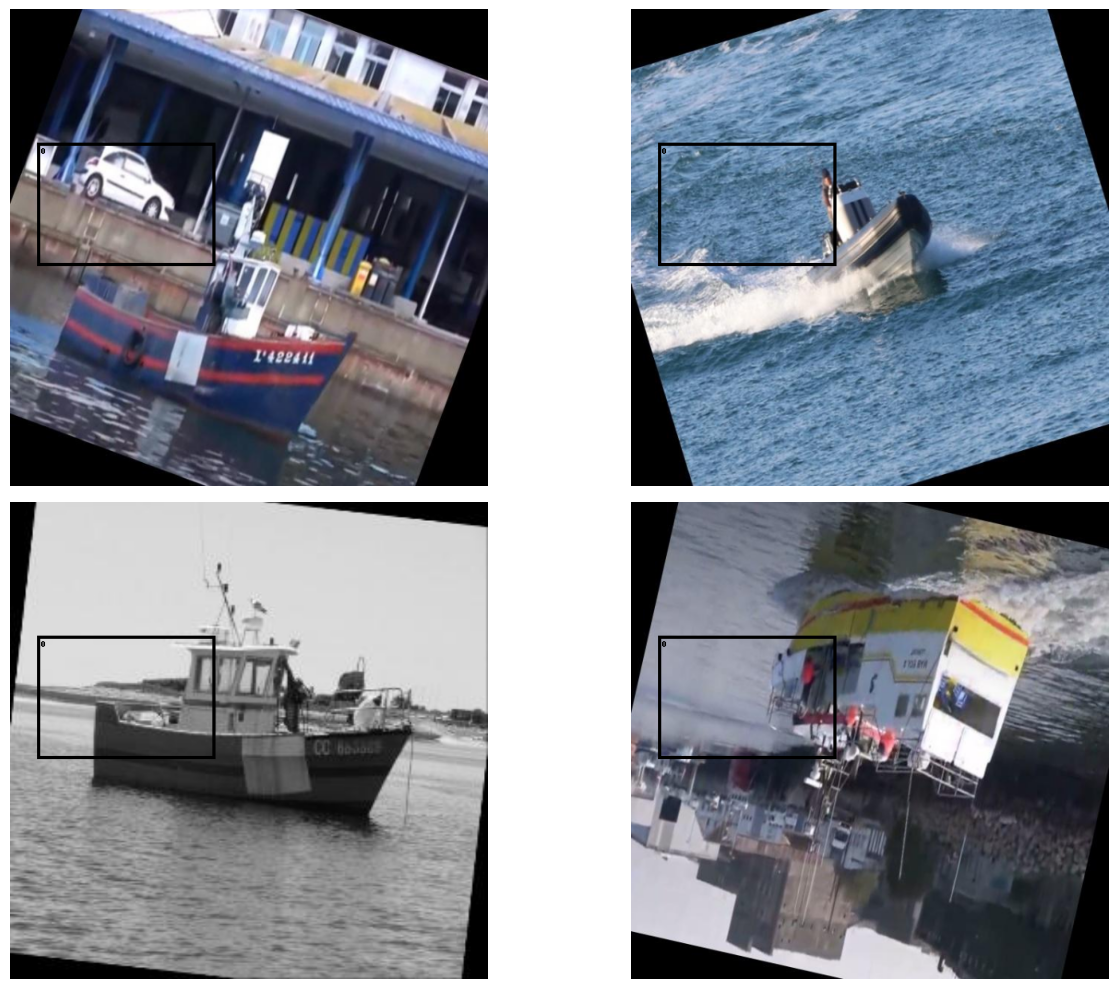

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loop through the subplots and plot the images with bounding boxes
for i, ax in enumerate(axes.flat):
    # Get the sample from the dataset
    sample = train_dataset[i]  # Assuming train_dataset contains the images and their corresponding annotations
    
    # Convert the image tensor to a numpy array
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
    
    # Perform prediction (replace this with your actual prediction code)
    # Assuming pred contains the predicted bounding boxes, labels, and scores
    pred_boxes = pred['boxes'][pred['scores'] > 0.8]
    pred_labels = [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()]
    
    # Draw bounding boxes on the image
    img_with_boxes = draw_bounding_boxes(img_int, pred_boxes, pred_labels, width=4).permute(1, 2, 0)
    
    # Plot the image with bounding boxes in the current subplot
    ax.imshow(img_with_boxes)
    ax.axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust the layout for better spacing between subplots
plt.show()  # Show the plot

In [28]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
# Mettez votre modèle en mode évaluation
model.eval()

# Liste pour stocker les prédictions et les vraies étiquettes
all_predictions = []
all_targets = []

# Boucle sur l'ensemble de test pour obtenir les prédictions et les étiquettes
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, target = test_dataset[i]
        prediction = model([img.to(device)])

        # Vérifiez si des prédictions ont été faites
        if 'labels' in prediction[0] and len(prediction[0]['labels']) > 0:
            # Convertir les boîtes prédites en classes
            pred_labels = [classes[i] for i in prediction[0]['labels'].tolist()]

            all_predictions.extend(pred_labels)
            all_targets.extend([classes[i] for i in target['labels'].tolist()])

# Assurez-vous que les listes ont la même longueur
if len(all_targets) != len(all_predictions):
    print("Nombre d'échantillons incorrects. Correction en cours...")
    min_length = min(len(all_targets), len(all_predictions))
    all_targets = all_targets[:min_length]
    all_predictions = all_predictions[:min_length]

# Calculer la précision et le rappel
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')

# Calculer la matrice de confusion
confusion = confusion_matrix(all_targets, all_predictions, labels=classes)

# Afficher les résultats
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Matrice de Confusion :")
print(confusion)

Nombre d'échantillons incorrects. Correction en cours...
Précision : 0.10
Rappel : 0.08
Matrice de Confusion :
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0  21   5  69  18  10   5   5  12  11   4]
 [  0   4   0   8   4   1   1   1   4   0   2]
 [  0  80  21 273  96  13  29  17  57  62  15]
 [  0  21   1  49  16   3   4   1   4   8   1]
 [  0   1   0   7   2   0   0   0   4   3   0]
 [  0   2   0   7   2   0   0   1   2   0   0]
 [  0   3   2  15   4   0   1   3   6   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0  25   6   0   3   1   4   3   2]
 [  0   2   0   0   0   0   0   0   0   4   0]]


In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import average_precision_score

# Convertir les étiquettes en format de liste de listes
mlb = MultiLabelBinarizer(classes=classes)
binarized_targets = mlb.fit_transform([[label] for label in all_targets])
binarized_predictions = mlb.transform([[label] for label in all_predictions])

# Calculer la précision moyenne
average_precision = average_precision_score(binarized_targets, binarized_predictions)

# Afficher les résultats
print("mAP : {:.2f}".format(average_precision))

mAP : 0.09


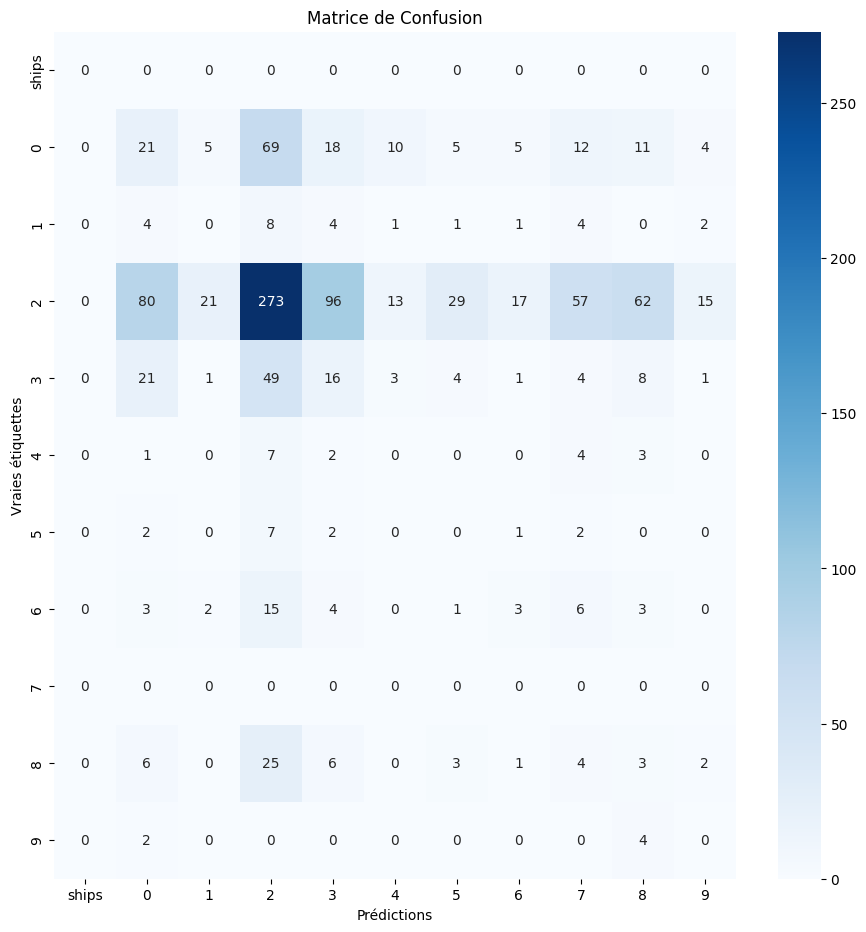

              precision    recall  f1-score   support

       ships       0.00      0.00      0.00         0
           0       0.15      0.13      0.14       160
           1       0.00      0.00      0.00        25
           2       0.60      0.41      0.49       663
           3       0.11      0.15      0.12       108
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        14
           6       0.10      0.08      0.09        37
           7       0.00      0.00      0.00         0
           8       0.03      0.06      0.04        50
           9       0.00      0.00      0.00         6

   micro avg       0.29      0.29      0.29      1080
   macro avg       0.09      0.08      0.08      1080
weighted avg       0.41      0.29      0.34      1080



In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # Importez seaborn ici


# ...

# Calculer la matrice de confusion
confusion = confusion_matrix(all_targets, all_predictions, labels=classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(len(classes), len(classes)))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification (precision, recall, f1-score, support) pour chaque classe
print(classification_report(all_targets, all_predictions, labels=classes))